# 2. Grouping songs together!

In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

## 2.1 Getting your data

I read the three datasets.

In [2]:
echo = pd.read_csv('./echonest.csv')

In [3]:
features = pd.read_csv('./features.csv')

In [4]:
tracks = pd.read_csv('./tracks.csv')

**Echonest dataset**

In [5]:
echo.info(max_cols=250)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Data columns (total 250 columns):
 #    Column                              Non-Null Count  Dtype  
---   ------                              --------------  -----  
 0    track_id                            13129 non-null  int64  
 1    audio_features_acousticness         13129 non-null  float64
 2    audio_features_danceability         13129 non-null  float64
 3    audio_features_energy               13129 non-null  float64
 4    audio_features_instrumentalness     13129 non-null  float64
 5    audio_features_liveness             13129 non-null  float64
 6    audio_features_speechiness          13129 non-null  float64
 7    audio_features_tempo                13129 non-null  float64
 8    audio_features_valence              13129 non-null  float64
 9    metadata_album_date                 2717 non-null   object 
 10   metadata_album_name                 2872 non-null   object 
 11   metadata_artist_latitude  

In [6]:
echo.shape

(13129, 250)

In [7]:
echo.head()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


**Features dataset**

In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr_std_01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB


In [9]:
features.shape

(106574, 519)

In [10]:
features.head()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


**Tracks dataset**

In [11]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   track_id                  106574 non-null  int64  
 1   album_comments            106574 non-null  int64  
 2   album_date_created        103045 non-null  object 
 3   album_date_released       70294 non-null   object 
 4   album_engineer            15295 non-null   object 
 5   album_favorites           106574 non-null  int64  
 6   album_id                  106574 non-null  int64  
 7   album_information         83149 non-null   object 
 8   album_listens             106574 non-null  int64  
 9   album_producer            18060 non-null   object 
 10  album_tags                106574 non-null  object 
 11  album_title               105549 non-null  object 
 12  album_tracks              106574 non-null  int64  
 13  album_type                100066 non-null  o

In [12]:
tracks.shape

(106574, 53)

In [13]:
tracks.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


### Merge of the dataset

In [14]:
a = set(tracks.columns)
b = set(echo.columns)
c = set(features.columns)

In [15]:
print(a & b & c)

{'track_id'}


We see that the only column that the three datasets have in common is the "track_id" column. so we will use this column as the key to join the three datasets.

In [16]:
two_docs= tracks.merge(features, on='track_id')

In [17]:
total = two_docs.merge(echo, on='track_id')

In [18]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Columns: 820 entries, track_id to temporal_features_223
dtypes: float64(764), int64(16), object(40)
memory usage: 82.2+ MB


In [19]:
total.shape

(13129, 820)

In [20]:
total.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


### Cleaning of the total dataset

I delete any duplicates.

In [21]:
total.drop_duplicates()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.676960,3.61288,13.316690,262.929749
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.082770,6.01864,16.673548,325.581085
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.926490,5.86635,16.013849,356.755737
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.414010,8.33319,21.317064,483.403809
4,134,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.267070,11.20267,26.454180,751.147705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,0,2015-09-09 14:39:58,2006-02-06 00:00:00,Daan Hendriks,0,18862,"<p>""Do you know a word that means both look at...",55904,Daan Hendriks,...,-1.721207,4.686078,0.213789,0.208800,0.007911,0.06395,2.040730,1.97678,8.144532,147.040405
13125,124862,0,2015-09-09 14:39:58,2006-02-06 00:00:00,Daan Hendriks,0,18862,"<p>""Do you know a word that means both look at...",55904,Daan Hendriks,...,-0.647897,1.282306,0.214586,0.181860,0.011247,0.06240,0.922360,0.85996,1.794739,6.321268
13126,124863,0,2015-09-09 14:39:58,2006-02-06 00:00:00,Daan Hendriks,0,18862,"<p>""Do you know a word that means both look at...",55904,Daan Hendriks,...,-0.771613,1.623510,0.180471,0.128185,0.010103,0.06222,2.251160,2.18894,5.578341,89.180328
13127,124864,0,2015-09-09 14:39:58,2006-02-06 00:00:00,Daan Hendriks,0,18862,"<p>""Do you know a word that means both look at...",55904,Daan Hendriks,...,-2.054143,7.927149,0.250178,0.219205,0.014851,0.06390,1.487440,1.42354,2.173092,12.503966


There are no duplicates because the number of lines has remained unchanged. I still have 13129 rows.

Now I replace missing numeric values with the mean and missing string values with a space.

In [22]:
for col in total.columns:
    if total[col].isnull().any() == True:
        if total[col].dtypes == 'object':
            total[col] = total[col].fillna("")
        else:
            val = total[col].mean()
            total[col] = total[col].fillna(val)

In [23]:
total.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,,4,6,,47632,,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


Finally I delete the symbols that are left in the columns containing strings, such as some html tags.

In [24]:
for col in total.columns:
    if total[col].dtypes == 'object':
        total[col] = total[col].str.replace(r'<[^<>]*>', '', regex=True)

In [25]:
total.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,,6073,,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,,6073,,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,,6073,,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,,4,6,,47632,,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,,6073,,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


### Choose your features (variable)

Now we need to reduce the size of our dataset. We want to use the PCA method.

Since we would like to apply PCA, first we should select all the numeric variables present in the dataset.

In [26]:
ds = total.select_dtypes([np.number])

But there are some numeric variables we don't want to be changed, like "album_id" and "artist_id". So for the moment we don't consider them. Once the reduction has been applied, we will reinsert the columns that will interest us.

In [27]:
ds = ds.drop(["album_id", "artist_id"], axis = 1)

In [28]:
print(ds.shape)
ds.head()

(13129, 778)


,track_id,album_comments,album_favorites,album_listens,album_tracks,artist_comments,artist_favorites,artist_latitude,artist_longitude,track_bit_rate,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0,4,6073,7,0,9,40.058324,-74.405661,256000,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0,4,6073,7,0,9,40.058324,-74.405661,256000,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0,4,6073,7,0,9,40.058324,-74.405661,256000,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0,4,47632,2,3,74,40.144635,-49.099826,192000,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0,4,6073,7,0,9,40.058324,-74.405661,256000,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


Before applying PCA we need to normalize the features. we do this using "preprocessing.StandardScaler" from the "sklearn" library. With this function we "standardize" the features by removing the mean and scaling to unit variance.

In [29]:
scaler = preprocessing.StandardScaler()

We standardize the whole dataset, but not the "track_id" column, because we don't want it to be changed.

In [30]:
temp_ds = pd.DataFrame(scaler.fit_transform(ds[ds.columns[1:]].values), columns = ds.columns[1:])

In [31]:
temp_ds.head()

,album_comments,album_favorites,album_listens,album_tracks,artist_comments,artist_favorites,artist_latitude,artist_longitude,track_bit_rate,track_comments,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,-0.293923,0.757754,-0.290607,-0.447065,-0.311831,-0.160959,-0.007064,-5.583029e-01,0.116230,-0.090184,...,-0.015394,-0.196498,-0.541629,-0.746474,-0.039156,-0.406800,-0.101961,-0.101075,0.886203,0.549691
1,-0.293923,0.757754,-0.290607,-0.447065,-0.311831,-0.160959,-0.007064,-5.583029e-01,0.116230,-0.090184,...,0.224575,-0.092590,-0.360448,-0.411759,-0.023682,-0.402225,0.382370,0.383292,1.407079,0.827430
2,-0.293923,0.757754,-0.290607,-0.447065,-0.311831,-0.160959,-0.007064,-5.583029e-01,0.116230,-0.090184,...,-0.188685,0.038956,-0.372166,-0.209735,-0.029780,-0.767287,0.350908,0.352630,1.304715,0.965630
3,-0.293923,0.757754,0.503120,-0.860517,0.293227,0.823212,0.000000,1.567615e-16,-0.886405,-0.090184,...,-0.993299,0.536708,-0.182877,0.139612,-0.010956,1.124812,0.851688,0.849294,2.127603,1.527072
4,-0.293923,0.757754,-0.290607,-0.447065,-0.311831,-0.160959,-0.007064,-5.583029e-01,0.116230,-0.090184,...,0.300454,-0.418382,-0.530095,-0.666811,-0.004175,-0.377522,1.426057,1.427025,2.924718,2.714005


Now we can apply PCA.

After some tests we noticed that to maintain at least 70% of the variance we need to have 75 components.

In [32]:
pca = PCA(n_components=75)
ds_pca = pca.fit_transform(temp_ds)

print(sum(pca.explained_variance_ratio_))

0.7165607481585103


In [33]:
final_temp_ds = pd.DataFrame(ds_pca, columns = ['Feature_%i' % i for i in range(75)])

In [34]:
print(final_temp_ds.shape)
final_temp_ds.head()

(13129, 75)


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_65,Feature_66,Feature_67,Feature_68,Feature_69,Feature_70,Feature_71,Feature_72,Feature_73,Feature_74
0,3.072908,-2.797796,-5.727769,4.277086,3.146236,2.027724,6.745503,-0.946781,-2.278286,4.300846,...,-1.217839,-0.164497,-1.025975,-0.499616,0.637262,-1.302603,-1.245148,1.185309,-2.006199,-1.132094
1,5.773259,-5.391672,-5.296378,-1.594689,-3.638799,2.656065,-1.536727,5.895195,-0.186648,4.205522,...,-1.259859,0.455182,0.473178,0.062921,0.233204,-1.084560,1.199023,1.229745,2.274795,0.375253
2,2.650793,-4.148118,-4.570424,-0.058433,-2.859295,2.087842,-1.289189,-0.333308,-0.131072,1.773382,...,0.729523,-1.013840,0.411180,-0.552804,-0.080880,-0.911748,0.282866,0.531354,0.959501,-1.289933
3,9.136524,3.851304,-5.450469,0.690601,-1.309867,0.610318,-1.808065,4.077166,-0.603567,4.950122,...,0.634112,3.933348,2.108527,0.523638,-3.058469,0.410922,1.313081,2.948067,-1.468791,-0.463599
4,1.305628,-9.430696,-4.284233,0.703173,-3.847979,-1.252908,-2.945814,-2.202982,-0.536387,2.533939,...,-0.470366,-0.643088,0.138726,-1.120528,0.993993,-1.956316,0.382696,-0.230915,1.784201,-0.515211


Now let's add some variables of interest that may be useful later.

In [35]:
final_temp_ds = pd.concat([total['track_genre_top'], final_temp_ds], axis = 1)

In [36]:
final_temp_ds = pd.concat([total['track_duration'], final_temp_ds], axis = 1)

In [37]:
final_temp_ds = pd.concat([total['audio_features_tempo'], final_temp_ds], axis = 1)

In [38]:
final_temp_ds = pd.concat([total['track_language_code'], final_temp_ds], axis = 1)

In [39]:
final_temp_ds = pd.concat([total['metadata_artist_location'], final_temp_ds], axis = 1)

At the end we add the "track_id" column again and we get the final dataset.

In [40]:
final_ds = pd.concat([total['track_id'], final_temp_ds], axis = 1)

In [41]:
print(final_ds.shape)
final_ds.head()

(13129, 81)


,track_id,metadata_artist_location,track_language_code,audio_features_tempo,track_duration,track_genre_top,Feature_0,Feature_1,Feature_2,Feature_3,...,Feature_65,Feature_66,Feature_67,Feature_68,Feature_69,Feature_70,Feature_71,Feature_72,Feature_73,Feature_74
0,2,"Georgia, US",en,165.922,168,Hip-Hop,3.072908,-2.797796,-5.727769,4.277086,...,-1.217839,-0.164497,-1.025975,-0.499616,0.637262,-1.302603,-1.245148,1.185309,-2.006199,-1.132094
1,3,"Georgia, US",en,126.957,237,Hip-Hop,5.773259,-5.391672,-5.296378,-1.594689,...,-1.259859,0.455182,0.473178,0.062921,0.233204,-1.084560,1.199023,1.229745,2.274795,0.375253
2,5,"Georgia, US",en,100.260,206,Hip-Hop,2.650793,-4.148118,-4.570424,-0.058433,...,0.729523,-1.013840,0.411180,-0.552804,-0.080880,-0.911748,0.282866,0.531354,0.959501,-1.289933
3,10,"Philadelphia, PA, US",en,111.562,161,Pop,9.136524,3.851304,-5.450469,0.690601,...,0.634112,3.933348,2.108527,0.523638,-3.058469,0.410922,1.313081,2.948067,-1.468791,-0.463599
4,134,"Georgia, US",en,114.290,207,Hip-Hop,1.305628,-9.430696,-4.284233,0.703173,...,-0.470366,-0.643088,0.138726,-1.120528,0.993993,-1.956316,0.382696,-0.230915,1.784201,-0.515211


We now need to implement the k-means algorithm. 

## Kmeans implementation

We are now going to implement the kmeans algorithm from scratch. First we need to do some preliminary code on our dataset, by standardizing each column (except track_id of course)

In [42]:
point0 = final_ds[[word for word in final_ds.columns
                     if word.startswith('Feature') 
                     or word == 'track_id'
                     or word == 'audio_features_tempo' 
                     or word == 'track_duration' 
                           ]]
scaler = StandardScaler()
scaler.fit(point0[[i for i in point0.columns if i != 'track_id']])
app = scaler.transform(point0[[i for i in point0.columns if i != 'track_id']])
X = pd.DataFrame(app)
point0 = pd.concat([point0['track_id'], X], axis = 1)

In [43]:
point0.describe()

,track_id,0,1,2,3,4,5,6,7,8,...,67,68,69,70,71,72,73,74,75,76
count,13129.000000,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,...,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,1.312900e+04,13129.000000,1.312900e+04,1.312900e+04
mean,34031.058268,4.264664e-16,-7.143853e-17,-1.082402e-17,-8.659215e-18,-2.597765e-17,8.659215e-18,-8.659215e-18,2.597765e-17,1.190642e-17,...,2.164804e-18,8.659215e-18,-1.785963e-17,4.329608e-18,2.164804e-18,1.136522e-17,-2.164804e-18,0.000000,7.576813e-18,8.659215e-18
std,28950.422182,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,...,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038,1.000038e+00,1.000038e+00
min,2.000000,-3.150959e+00,-1.114606e+00,-3.977082e+00,-3.364318e+00,-5.000122e+00,-2.774328e+00,-4.222549e+00,-5.044692e+00,-5.971230e+00,...,-1.073262e+01,-1.480466e+01,-9.306834e+00,-1.406526e+01,-9.898777e+00,-1.257312e+01,-1.104969e+01,-14.579071,-1.183476e+01,-1.144702e+01
25%,12986.000000,-7.743535e-01,-4.487766e-01,-6.264504e-01,-6.650043e-01,-6.298712e-01,-6.575926e-01,-6.388042e-01,-6.207736e-01,-6.138881e-01,...,-5.477718e-01,-4.862916e-01,-5.222917e-01,-5.587445e-01,-5.290779e-01,-5.489204e-01,-5.609869e-01,-0.544141,-5.725308e-01,-5.720854e-01
50%,28097.000000,-8.633912e-02,-1.689352e-01,5.366117e-02,2.590340e-02,6.522258e-03,-9.866033e-02,1.308670e-02,-1.215190e-02,-4.410946e-02,...,1.727745e-02,5.798458e-02,-1.679141e-02,-7.599828e-03,4.229371e-02,-1.036128e-03,1.040528e-02,-0.002817,2.180904e-03,1.511260e-02
75%,45021.000000,6.351192e-01,1.591547e-01,6.676037e-01,6.437601e-01,6.484252e-01,5.225248e-01,6.365534e-01,5.918627e-01,5.646072e-01,...,5.567726e-01,5.498258e-01,5.102039e-01,5.481246e-01,5.688267e-01,5.506530e-01,5.611596e-01,0.530627,5.864916e-01,6.037092e-01
max,124911.000000,3.655471e+00,1.343232e+01,5.900886e+00,8.051513e+00,9.850660e+00,2.015935e+01,1.662949e+01,1.446126e+01,7.058238e+00,...,2.231572e+01,2.285523e+01,1.840213e+01,2.408247e+01,1.399686e+01,2.208826e+01,1.279253e+01,21.398317,1.339941e+01,2.270120e+01


The implemented kmeans function starts by randomly generating centroids, and then comparing the new estimate with the old one. If the difference is smaller than a certain threshold, the function stops and returns the clusters in the form of a list of sets 

In [61]:
def vectextract(trackid: int):
    """
    This function takes as input the track_id identifier and returns the corresponding
    row in the dataset  
    
    :param point:         the track_id of the dataset we are interested in 
    :retuns:              the row of the dataset we are interested in
    """
    point = point0[point0['track_id'] == trackid]
    point = np.array(point[[word for word in point.columns
                     if word != 'track_id' 
                           ]])
    return point

def distance(track1: int, centroid):
    """
    This function calculates the distance between a point and a centroid.
    
    :param track1:        track_id identifier of the point
    :param centroid:      row of coordinates of the centroid
    :retuns:              euclidean distance between the point and the centroid
    """
    point1 = vectextract(track1)
    point1 = np.transpose(point1)
    return np.sqrt(np.sum([(point1[i] - centroid[i]) ** 2 
                 for i in range(len(point1))]))

def naive_kmeans(k:int, points, eps):
    """
    Made-from-scartch version of KMeans
       
    :param k:             number of clusters
    :param point:         list of points, identified by the track_id value
    :param eps:           tolerance level to stop the algorithm
    :retuns:              list of sets of points. Each set is a cluster
    """
    # First I need to create the first centroids by random
    centroids = np.random.choice(len(points), k, replace=False)
    centroids = [vectextract(points[i]) for i in centroids]
    app = np.zeros((np.array(centroids).shape[0], np.array(centroids).shape[2]))
    for row in range(np.array(centroids).shape[0]):
        for col in range(np.array(centroids).shape[2]):
            app[row][col] = centroids[row][0][col]
    centroids = app
    while True:
        # Initializing a few more variables...
        centroids_update = centroids * 0
        c = [set() for i in range(k)]
        for x in points:
            # j is the index of the closest centroid to x
            j = np.argmin(np.array([distance(x, i) for i in centroids]))
            # so we add x to the cluster of centroid j
            c[j].add(x)
        for i in range(k):
            for pnt in c[i]:
                # The new centroid is the mean of all points in the cluster
                centroids_update[i] += np.transpose(vectextract(pnt)[0])
            if len(c[i]):
                centroids_update[i] /= len(c[i])
        # Here we check if the old and new centroids are close enough
        cond = cdist(centroids_update, centroids,'euclidean').all() <= eps
        if cond:  
            # print(centroids)
            val = 0
            for i in range(k):
                content = [np.transpose(vectextract(pnt)[0]) for pnt in c[i]]
                val += np.var(np.array(content))
            final = [c, np.var(centroids), val]
            return c
        centroids = centroids_update
        

def naive_kmeans2(k:int, points, eps):
    """
    Made-from-scartch version of KMeans
       
    :param k:             number of clusters
    :param point:         list of points, identified by the track_id value
    :param eps:           tolerance level to stop the algorithm
    :retuns:              variance between centroids and sum of variances inside clusters
    """
    # First I need to create the first centroids by random
    centroids = np.random.choice(len(points), k, replace=False)
    centroids = [vectextract(points[i]) for i in centroids]
    app = np.zeros((np.array(centroids).shape[0], np.array(centroids).shape[2]))
    for row in range(np.array(centroids).shape[0]):
        for col in range(np.array(centroids).shape[2]):
            app[row][col] = centroids[row][0][col]
    centroids = app
    iter_ = 0
    while True:
        iter_ += 1
        # Initializing a few more variables...
        centroids_update = centroids * 0
        c = [set() for i in range(k)]
        for x in points:
            # j is the index of the closest centroid to x
            j = np.argmin(np.array([distance(x, i) for i in centroids]))
            # so we add x to the cluster of centroid j
            c[j].add(x)
        for i in range(k):
            for pnt in c[i]:
                # The new centroid is the mean of all points in the cluster
                centroids_update[i] += np.transpose(vectextract(pnt)[0])
            if len(c[i]):
                centroids_update[i] /= len(c[i])
        # Here we check if the old and new centroids are close enough
        cond = cdist(centroids_update, centroids,'euclidean').all() <= eps or iter_>=35
        if cond:  
            # print(centroids)
            val = 0
            for i in range(k):
                content = [np.transpose(vectextract(pnt)[0]) for pnt in c[i]]
                val += np.var(np.array(content))
            return (np.var(centroids), val)
        centroids = centroids_update

In [45]:
n_cluster_ = 6
naive_clusters = naive_kmeans(n_cluster_, np.array(point0['track_id']), 0.01)


In [46]:
kmeans = KMeans(n_clusters=n_cluster_, init='k-means++', random_state=0).fit(X)
clusters = [set() for i in range(n_cluster_)]
for x in point0['track_id']:
    j = np.argmin(np.array([distance(x, i) for i in kmeans.cluster_centers_]))
    clusters[j].add(x)
print([len(i) for i in clusters])

[226, 4330, 106, 610, 4366, 3491]


2
3
4
5
6
7


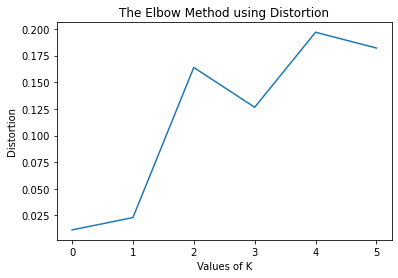

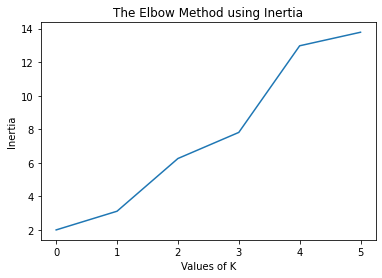

In [47]:
distortions = []
inertias = []

for i in range(2, 8):
    a, b = naive_kmeans2(i, np.array(point0['track_id']), 0.1)
    distortions.append(a)
    inertias.append(b)
    print(i)
    
plt.plot(distortions)
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

plt.plot(inertias)
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

The elbow method does not really indicate anything here, because the algorithm is too sensitive on initialization do draw conclusion over which number of clusters is best

In [48]:
def find_in_dic(dic, query):
    """
    Finds the key in a dictionary whose value (a set) contains the query
    
    :param dic:           the dictionary of sets
    :param query:         the value that we have 
    :retuns:              the key such that query in dic[key]
    """
    for key in dic:
        if query in dic[key]:
            return key
    return 'Error'
def find_in_list(lis, value):
    """
    Finds the index in a list whose value (a set) contains the query
    
    :param lis:           the list of sets
    :param value:         the value that we have 
    :retuns:              the index i such that query in lis[i]
    """
    for i in range(len(lis)):
        if value in lis[i]:
            return i

def find_in_list2(lis, value):
    """
    Finds the index in a list whose value is the query
    
    :param lis:           the list 
    :param value:         the value that we have 
    :retuns:              the index i such that query == lis[i]
    """
    for i in range(len(lis)):
        if value == lis[i]:
            return i

def getpossval(tag, ds):
    """
    Returns a list of 4 values to put in the pivot table. If the values we are considering
    are not numeric, it takes only the 4 most popular ones, otherwise it divides the values
    quantiles
    
    :param tag:           the column of the dataset we are considering
    :param ds:            the dataset
    :retuns:              the list of possible values we are considering
    """
    if tag in ['album_producer', 'track_language_code',
               'track_genre_top', 'artist_members']:
            poss_values = list(pd.unique(tracks[tag]))
            if len(poss_values) > 4 and tag != 'track_genre_top' and tag != 'track_language_code':
                poss_values = tracks[tag].value_counts().keys()[0:4]
            return poss_values
    lis = []
    for i in range(1,4):
        lis.append(ds[tag].quantile(.25*i))
    lis.append(ds[tag].max())
    return lis

def cat(value, tag, poss_values):
    """
    Puts each value in the right category: in particular if the value is numeric, it will
    put it in the right quantile.
    
    :param value:         the actual value
    :param tag:           the column of the dataset
    :param poss_values:   the list of all possible values which has the quantiles
    :retuns:              the category we are putting the value in
    """
    if tag in ['album_producer', 'track_language_code',
               'track_genre_top', 'artist_members']:
        return value
    for i in range(len(poss_values)):
        if value <= poss_values[i]:
            return [poss_values[i]]

In [49]:
tags = ['artist_longitude',
        'artist_latitude',
        'track_duration',
        'album_listens',
        'track_language_code', 'track_genre_top']
list_of_tables = []
for tag in tags:
    # Here we create a list of values we will display in our table
    poss_values = getpossval(tag, tracks)
    # Initializing a dictionary of sets, each set is for a value of the table and
    #      contains all the points that fall under that variable
    dic = {i: set() for i in poss_values}
    for trackid in final_ds['track_id']:
        # Finding the value of column tag for index track_id
        tracktag = list(tracks[tag][tracks['track_id'] == trackid])
        # Putting that value in the right category
        tracktag = cat(tracktag, tag, poss_values)
        try:
            dic[tracktag[0]].add(trackid)
        except Exception as e:
            pass
    # Initializing the pivot table
    table = np.zeros((n_cluster_, len(poss_values)))
    for i in np.array(final_ds['track_id']):
        # Finding where in the pivot table each point goes
        tag_ = find_in_dic(dic, i)
        b = find_in_list2(poss_values, tag_)
        a = find_in_list(naive_clusters, i)
        if a is None or b is None:
            continue
        table[a][b] += 1
    # Normalizing the pivot table
    for z in range(len(table)):
        if np.sum(table[z]) != 0:
            table[z] /= np.sum(table[z])
    table = np.transpose(table)
    table = pd.DataFrame(table)  
    table.index = poss_values
    table = table[(table.T != 0).any()]
    list_of_tables.append(table)

In the continuous variables I have decided to break the variables into four categories by looking at quantiles. In other words I picked different intervals so that the prior probability of for a song to be in a specific category is 0.25. This way it is even easier to understand and appreciate the effect of clustering, as a higher or lower value in the table is entirely an effect of clusterization (and not of some ill-picked categorization)

In [50]:
print(tags[0])

list_of_tables[0].index = ['-180 : -79.99', '-79.98 : -73.55', '-73.54 : 4.35', '4.36+']
list_of_tables[0]

artist_longitude


,0,1,2,3,4,5
-180 : -79.99,0.333935,0.283458,0.316002,0.367347,0.222727,0.183908
-79.98 : -73.55,0.287906,0.219451,0.288743,0.183673,0.190909,0.183908
-73.54 : 4.35,0.201264,0.245636,0.189046,0.163265,0.325000,0.149425
4.36+,0.176895,0.251455,0.206209,0.285714,0.261364,0.482759


In this table we can observe that latitude -180 : -79.99 is dominant in cluster 0, 1, 2, and 3 while in cluster 4 latitude -73.54 : 4.35 is predominant and in cluster 5 latitude 4.36+ is where most values are

In [51]:
print(tags[1])
list_of_tables[1].index = ['-90 : 39.27', '39.28 : 41.38', '41.39 : 48.85', '48.86+']
list_of_tables[1]

artist_latitude


,0,1,2,3,4,5
-90 : 39.27,0.326715,0.273067,0.278900,0.244898,0.179545,0.149425
39.28 : 41.38,0.277978,0.229426,0.300858,0.244898,0.220455,0.126437
41.39 : 48.85,0.206679,0.251455,0.242807,0.183673,0.281818,0.367816
48.86+,0.188628,0.246052,0.177436,0.326531,0.318182,0.356322


In this table we can see that in cluster 0 we have that most tracks have latitude -90 : 39.27, in cluster 1 we have that most songs have latitude  48.86+, in cluster 2 we have that most songs have latitude 39.28 : 41.38, in clister 3 most songs have latitude 48.86+, in cluster 4 and 5most songs have latitude 41.39 : 48.85

In [52]:
print(tags[2])
list_of_tables[2].index = ['0 : 149', '150 : 216', '217 : 305', '306+']
list_of_tables[2]

track_duration


,0,1,2,3,4,5
0 : 149,0.206897,0.041124,0.323723,0.426966,0.340938,0.474074
150 : 216,0.350272,0.152264,0.349753,0.292135,0.299113,0.274074
217 : 305,0.307169,0.331078,0.265568,0.191011,0.248416,0.133333
306+,0.135662,0.475534,0.060956,0.089888,0.111534,0.118519


We can see that tracks in cluster 0 and 2 have a duration which is most likely in 150 : 216, in cluster 1 they usually have duration greater than 306, in cluster 3, 4 and 5 they have duration below 149

In [53]:
print(tags[3])
list_of_tables[3].index = ['0 : 3361', '3362 : 8982', '8983 : 23635', '23636+']
list_of_tables[3]

album_listens


,0,1,2,3,4,5
0 : 3361,0.194646,0.309214,0.326524,0.202247,0.250951,0.200000
3362 : 8982,0.270417,0.270953,0.300988,0.202247,0.247148,0.251852
8983 : 23635,0.292650,0.242061,0.234596,0.235955,0.290241,0.133333
23636+,0.242287,0.177772,0.137891,0.359551,0.211660,0.414815


In cluster 0 the mode of number of listens is in 8983 : 23635, in cluster 1 and 2 it is below 3361, in cluster 3 and 5 it is over 23636, in cluster 4 it is 8983 : 23635

In [54]:
print(tags[4])
list_of_tables[4]

track_language_code


,0,1,2,3,4,5
en,0.960883,0.966932,0.950901,1.0,0.966667,1.0
es,0.011033,0.014085,0.025786,0.0,0.020000,0.0
fi,0.000000,0.000612,0.000353,0.0,0.003333,0.0
pt,0.015045,0.003062,0.002119,0.0,0.000000,0.0
tr,0.003009,0.004287,0.003886,0.0,0.000000,0.0
sw,0.000000,0.000000,0.001766,0.0,0.000000,0.0
el,0.001003,0.000612,0.001060,0.0,0.000000,0.0
ar,0.001003,0.002449,0.000000,0.0,0.000000,0.0
fr,0.005015,0.001225,0.004239,0.0,0.006667,0.0
ja,0.000000,0.000612,0.000706,0.0,0.000000,0.0


In this table we see the effect of having a very strong prior probability of being in English: in each cluster the language that is most likely to happen is English, while any other language is negligible

In [55]:
print(tags[5])
list_of_tables[5]

track_genre_top


,0,1,2,3,4,5
Hip-Hop,0.057308,0.039615,0.157670,0.072727,0.017657,0.025641
Pop,0.041854,0.034231,0.041386,0.018182,0.011236,0.000000
Rock,0.316162,0.302692,0.555106,0.200000,0.203852,0.102564
Experimental,0.001932,0.000385,0.002699,0.000000,0.001605,0.000000
Folk,0.169994,0.121154,0.059829,0.127273,0.004815,0.243590
Jazz,0.019317,0.051923,0.015969,0.000000,0.006421,0.012821
Electronic,0.108822,0.370385,0.120108,0.454545,0.731942,0.294872
International,0.010947,0.011154,0.017319,0.000000,0.012841,0.025641
Blues,0.005795,0.008846,0.007197,0.000000,0.003210,0.000000
Classical,0.057308,0.042692,0.008097,0.109091,0.001605,0.282051


Since we can interpret each column of the table as a vector of probabilities, we have that conditioned on being in a certain cluster, a song is most likely respectively Folk, Electronic, Rock, Electronic, Electronic, and Classical. 

# Algorithmic question

There are several ways to work on this problem: here in particular I will put three solutions, one with cost $\theta(n^2)$, another of $\theta(n\log n)$ and a final one with linear cost.

## First solution



Here we are going to sum every possible pair (counted only once) and we are going to check if their sum matches the query

In [56]:
def checksum1(lis: list, q: int):
    ris = []
    for i in range(len(lis)):
        for j in range(i+1,len(lis)):
            if lis[i]+lis[j] == q:
                ris.append((lis[i], lis[j]))
    return ris

In [57]:
checksum1([7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3], 4)

[(7, -3), (-2, 6), (2, 2), (1, 3)]

## Second solution

In this second solution we are going to sort the list first (with a cost of $n\log n$), and then we are going to leverage the new structure of the list and make only very specific comparisons: we are going to sum the first and the last element of the list and then compare it with our query. If the sum is greater than our query we are going to move from the first to the second element; similarly on the end side if our sum is smaller than the query. Since we are going to move at least one element at every comparison, we are going to make at most $n$ comparisons

In [58]:
def checksum2(lis: list, q: int):
    ris = []
    lis.sort()
    i = 0
    j = len(lis)
    while(i < j):
        if lis[i] + lis[j-1] == q:
            ris.append((lis[i], lis[j-1]))
            i += 1
            j -= 1
        elif lis[i] + lis[j-1] > q:
            j -= 1
        else:
            i += 1
    return ris

In [59]:
checksum2([7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3], 4)

[(-3, 7), (-2, 6), (1, 3), (2, 2)]

## Third solution

We can observe that every pair is uniquely identified by the difference between one term and the query. This means that using an additional data structure (such as a hash table) we can go through all the elements of the list exactly once and for each of them check if the hash table was already visited in the place corresponding to this difference. This means that if visiting and writing time are both constant in hash tables the total cost of the algorithm is going to be linear. Of course using a hash map has its risks: every collision is going to result in a false positive, but good hashing algorithms should make this event negligeable (below we have pseudocode)

In [60]:
def checksum3(lis: list, q: int):
    ris = []
    hashtable.create() # create an empty hash table
    for i in lis:
        a = abs(q-i)
        if hashtable[hashmap(a)]: #if the position is not empty we have already visited it
            ris.append((q-a, q+a))
        else:
            hashtable[hashmap(a)] = True #otherwise we mark our visit
    return ris